In [ ]:
from google.colab import files

uploads = files.upload()

Saving translated_labeled_tweets.csv to translated_labeled_tweets.csv


In [ ]:
! pip install "jax[cuda12_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install pymc arviz

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [ ]:
import pymc as pm
! pip install --upgrade pymc[jax] arviz

In [ ]:
import os
os.environ["PYMC_BACKEND"] = "jax"

In [ ]:
import pandas as pd
import arviz as az
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('translated_labeled_tweets.csv')
df['misinformation_label'].unique()

array(['valid', 'misleading', 'invalid'], dtype=object)

In [ ]:
df['is_misinfo'] = (df['misinformation_label'] != 'valid').astype(int)
lex = df['lexical_diversity'].to_numpy()
ent = df['entropy'].to_numpy()
mis = df['is_misinfo'].to_numpy()
eng = df['engagement'].to_numpy()


In [ ]:

df["p_left"]=(df["affiliated"]=="Left").astype(int)
df["p_right"]=(df["affiliated"]=="Right").astype(int)

mis=df["is_misinfo"].to_numpy()
p_left=df["p_left"].to_numpy()

p_right=df["p_right"].to_numpy()

user_idx=LabelEncoder().fit_transform(df["tweet.user.screen_name"])
n_users=user_idx.max()+1

coords={"coef":["mis","lex","ent","l","r","lm","rm"],
        "effect":["int","mis","lex","ent"],
        "user":np.arange(n_users)}
ix={k:coords["coef"].index(k) for k in coords["coef"]}

with pm.Model(coords=coords) as model:
    beta=pm.Normal("beta",0,2,dims="coef")
    mu_u=pm.Normal("mu_u",0,5,dims="effect")
    chol,corr,stds=pm.LKJCholeskyCov("chol",n=4,eta=2,
                                     sd_dist=pm.Exponential.dist(1),
                                     compute_corr=True)
    u_raw=pm.Normal("u_raw",0,1,shape=(n_users,4),dims=("user","effect"))
    u=pm.Deterministic("u",mu_u+u_raw@chol.T,dims=("user","effect"))

    eta=(u[user_idx,0]+
         (beta[ix["mis"]]+u[user_idx,1])*mis+
         (beta[ix["lex"]]+u[user_idx,2])*lex+
         (beta[ix["ent"]]+u[user_idx,3])*ent+
         beta[ix["l"]]*p_left+
         beta[ix["r"]]*p_right+
         beta[ix["lm"]]*p_left*mis+
         beta[ix["rm"]]*p_right*mis)

    mu_=pm.math.exp(eta)
    theta=pm.Exponential("theta",1)
    pm.NegativeBinomial("obs",mu=mu_,alpha=theta,observed=eng)
    idata=pm.sample(1000,tune=1000,target_accept=.9)

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
summary = az.summary(
    idata
)
summary

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[mis],-0.186,1.877,-3.860,3.355,0.128,0.065,217.0,380.0,1.00
beta[lex],0.138,1.833,-3.336,3.464,0.148,0.073,155.0,342.0,1.03
beta[ent],-0.002,1.926,-3.763,3.393,0.161,0.069,143.0,354.0,1.03
beta[l],0.014,2.007,-3.843,3.562,0.083,0.044,591.0,1093.0,1.01
beta[r],0.118,1.953,-3.506,3.754,0.095,0.050,425.0,645.0,1.01
...,...,...,...,...,...,...,...,...,...
"u_raw[12, ent]",1.135,0.685,-0.127,2.402,0.064,0.028,114.0,216.0,1.03
"u_raw[13, int]",0.643,0.394,-0.088,1.379,0.048,0.020,74.0,176.0,1.06
"u_raw[13, mis]",-0.169,0.549,-1.296,0.767,0.044,0.033,164.0,150.0,1.01
"u_raw[13, lex]",-0.689,0.491,-1.638,0.197,0.049,0.021,103.0,254.0,1.06


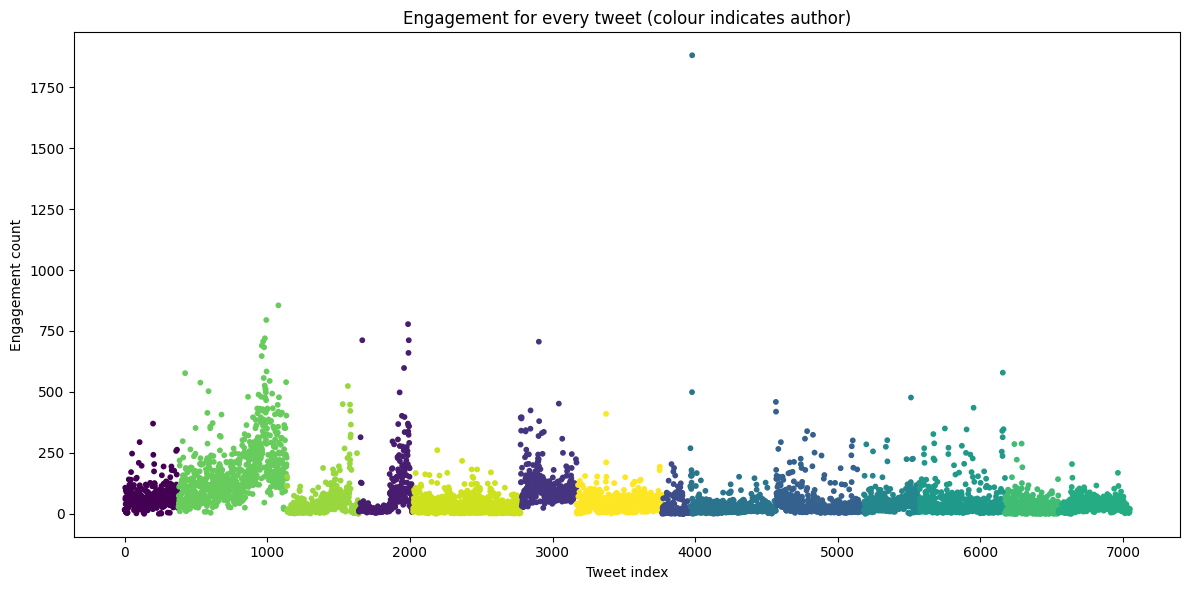

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

user_idx = LabelEncoder().fit_transform(df["tweet.user.screen_name"])

plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df["engagement"], c=user_idx, s=10)
plt.xlabel("Tweet index")
plt.ylabel("Engagement count")
plt.title("Engagement for every tweet (colour indicates author)")
plt.tight_layout()
plt.show()

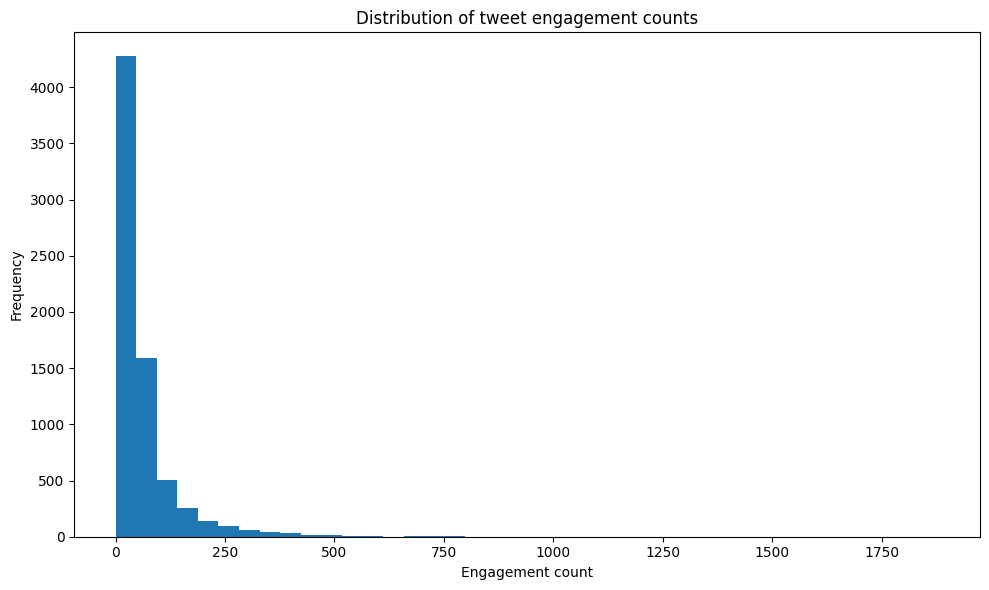

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["engagement"], bins=40)
plt.xlabel("Engagement count")
plt.ylabel("Frequency")
plt.title("Distribution of tweet engagement counts")
plt.tight_layout()
plt.show()


<ipython-input-15-810264521>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap  = plt.cm.get_cmap("tab20", len(users))


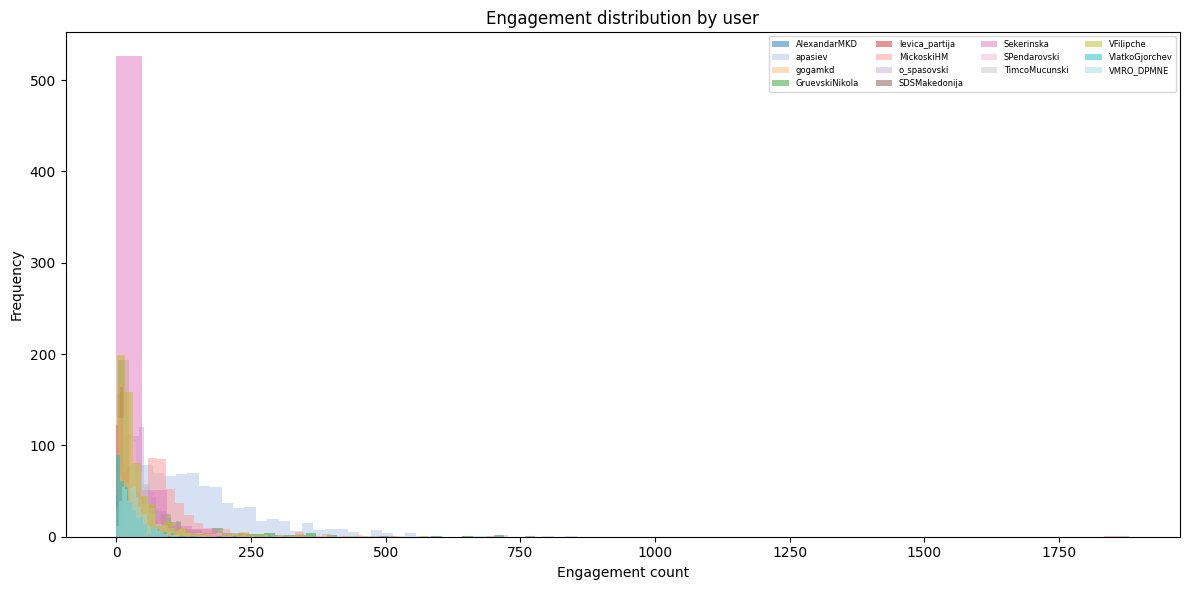

In [ ]:

users = df["tweet.user.screen_name"].unique()
cmap  = plt.cm.get_cmap("tab20", len(users))

plt.figure(figsize=(12,6))
for i, u in enumerate(users):
    plt.hist(df[df["tweet.user.screen_name"]==u]["engagement"],
             bins=40, color=cmap(i), alpha=.5, label=u)

plt.xlabel("Engagement count")
plt.ylabel("Frequency")
plt.title("Engagement distribution by user")
plt.legend(fontsize=6, ncol=4)
plt.tight_layout()
plt.show()
